# Getting Started with Llama Stack !

This notebook will walk you throught the steps to get started on LlamaStack
The first few steps need to happen outside of this notebook to get a stack server running.
Please look at this [guide](https://github.com/meta-llama/llama-stack/blob/main/docs/getting_started.md) for detailed instructions. 

For more client examples for other apis ( agents, memory, safety ) in llama_stack please refer to the [llama-stack-apps](https://github.com/meta-llama/llama-stack-apps/tree/main/examples).

In this notebook, we will showcase a few things to help you get started,
- Start the Llama Stack Server 
- How to use simple text and vision inference llama_stack_client APIs

### Starting the Llama Stack Server 

1. Get Docker container
```
$ docker login
$ docker pull llamastack/llamastack-local-gpu
```

2. pip install the llama stack client package 
For this purpose, we will directly work with pre-built docker containers and use the python SDK
```
$ git clone https://github.com/meta-llama/llama-stack-apps.git
$ cd llama-stack-apps
$ yes | conda create -n stack-test python=3.10 
$ conda activate stack-test
$ pip install llama_stack llama_stack_client
```
This will install `llama_stack` and `llama_stack_client` packages. 
This will enable you to use the `llama` cli. 

3. Download model 
```
$ llama download --help 
$ llama download --source meta --model-id Llama3.2-11B-Vision-Instruct --meta-url <META_URL>
```

4. Configure the Stack Server
```
For GPU inference, you need to set these environment variables for specifying local directory containing your model checkpoints, and enable GPU inference to start running docker container.
$ export LLAMA_CHECKPOINT_DIR=~/.llama
$ llama stack configure llamastack-local-gpu
```
Follow the prompts as part of configure.
Here is a sample output 
```
$ llama stack configure llamastack-local-gpu

Could not find /home/hjshah/.conda/envs/llamastack-llamastack-local-gpu/llamastack-local-gpu-build.yaml. Trying docker image name instead...
+ podman run --network host -it -v /home/hjshah/.llama/builds/docker:/app/builds llamastack-local-gpu llama stack configure ./llamastack-build.yaml --output-dir /app/builds

Configuring API `inference`...
=== Configuring provider `meta-reference` for API inference...
Enter value for model (default: Llama3.1-8B-Instruct) (required): Llama3.2-11B-Vision-Instruct
Do you want to configure quantization? (y/n): n
Enter value for torch_seed (optional): 
Enter value for max_seq_len (default: 4096) (required): 
Enter value for max_batch_size (default: 1) (required): 

Configuring API `safety`...
=== Configuring provider `meta-reference` for API safety...
Do you want to configure llama_guard_shield? (y/n): n
Do you want to configure prompt_guard_shield? (y/n): n

Configuring API `agents`...
=== Configuring provider `meta-reference` for API agents...
Enter `type` for persistence_store (options: redis, sqlite, postgres) (default: sqlite): 

Configuring SqliteKVStoreConfig:
Enter value for namespace (optional): 
Enter value for db_path (default: /root/.llama/runtime/kvstore.db) (required): 

Configuring API `memory`...
=== Configuring provider `meta-reference` for API memory...
> Please enter the supported memory bank type your provider has for memory: vector

Configuring API `telemetry`...
=== Configuring provider `meta-reference` for API telemetry...

> YAML configuration has been written to /app/builds/local-gpu-run.yaml.
You can now run `llama stack run local-gpu --port PORT`
YAML configuration has been written to /home/hjshah/.llama/builds/docker/local-gpu-run.yaml. You can now run `llama stack run /home/hjshah/.llama/builds/docker/local-gpu-run.yaml`
```
NOTE: For this example, we use all local meta-reference implementations and have not setup safety. 

5.  Run the Stack Server
```
$ llama stack run local-gpu --port 5000
```

The server has started correctly if you see outputs like the following 
```
...
...
Listening on :::5000
INFO:     Started server process [1]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://[::]:5000 (Press CTRL+C to quit)
```

### Llama Stack Client examples

In [2]:
from llama_stack_client import LlamaStackClient

In [5]:
host = "localhost"
port = 5000
client = LlamaStackClient(base_url=f"http://{host}:{port}")

In [10]:
# For this notebook we will be working with the latest Llama3.2 vision models 
model = "Llama3.2-11B-Vision-Instruct"

### Inference APIs ( chat_completion ) 

In [19]:
# Simple text example 
iterator = client.inference.chat_completion(
    model=model,
    messages=[
        {
            "role": "user",
            "content": "Write a haiku on llamas"
        }
    ],
    stream=True
)

for chunk in iterator:
    print(chunk.event.delta, end="", flush=True)

Fuzzy, gentle soul
Softly humming, calm delight
Llama's gentle gaze

### Multimodal Inference 

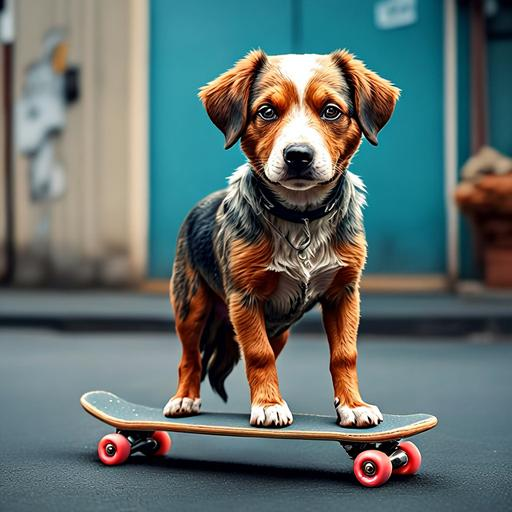

In [24]:
import base64
import mimetypes 

from PIL import Image

# We define a simple utility function to take a local image and 
# convert it to as base64 encoded data url 
# that can be passed to the server. 
def data_url_from_image(file_path):
    mime_type, _ = mimetypes.guess_type(file_path)
    if mime_type is None:
        raise ValueError("Could not determine MIME type of the file")

    with open(file_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")

    data_url = f"data:{mime_type};base64,{encoded_string}"
    return data_url

with open("dog.jpg", "rb") as f:
    img = Image.open(f).convert("RGB")

img.show()


In [25]:
# we can reuse the same chat_completion interface for multimodal inference too
# Use path to local file
data_url = data_url_from_image("dog.jpg")
iterator = client.inference.chat_completion(
    model=model,
    messages=[
        {
            "role": "user",
            "content": [
                { "image": { "uri": data_url } }, 
                "Write a haiku describing the image"
            ]
        }
    ],
    stream=True
)

for chunk in iterator:
    print(chunk.event.delta, end="", flush=True)

A puppy on a skateboard,
Paws gripping the board with care,
Learning to ride with grace.